In [1]:
import pandas as pd
import numpy as np
import json
import os
from tqdm.notebook import tqdm
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter, defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string

In [2]:
def get_outlier(data):
    Q1 = np.percentile(data, 25, method = 'midpoint') 
    Q2 = np.percentile(data, 50, method = 'midpoint') 
    Q3 = np.percentile(data, 75, method = 'midpoint')
    
    IQR = Q3 - Q1
    
    low_lim = max(Q1 - 1.5 * IQR,min(data))
    up_lim = min(Q3 + 1.5 * IQR, max(data))
    
    return Q2, IQR, low_lim, up_lim

### Summary Table

In [3]:
summary_table = []

In [4]:
user_index = json.load(open("../data/user_index.json",'r'))
commitment_index = json.load(open("../data/commitment_index.json",'r'))

counters = json.load(open("../data/counter.json",'r'))
with open("../data/users_not_found.txt",'r') as fp:
    user_not_found = fp.readlines()
    
with open("../data/private_users.txt",'r') as fp:
    private_users = fp.readlines()
    
user_not_found = [int(i.strip()) for i in user_not_found]
private_users = [int(i.strip()) for i in private_users]

In [5]:
max_user_id = max([int(i) for i in user_index.keys()])

In [6]:
for k,v in tqdm(user_index.items()):
    user_index[k]['date'] = datetime.strptime(v['date'], '%d %b %Y')

  0%|          | 0/521632 [00:00<?, ?it/s]

In [7]:
id_for_1_jan_2023 = 722621
for k,v in tqdm(user_index.items()):
    if int(k)<id_for_1_jan_2023 and v['date'].year == 2023:
        user_index[k]['date'] = None

  0%|          | 0/521632 [00:00<?, ?it/s]

In [8]:
last_date = user_index['1']['date']
for i in range(1, max_user_id+1):
    if str(i) in user_index.keys():
        if user_index[str(i)]['date'] == None:
            user_index[str(i)]['date'] = last_date
        else:
            last_date = user_index[str(i)]['date']

In [9]:
for k,v in tqdm(commitment_index.items()):
    commitment_index[k]['start_date'] = datetime.strptime(v['start_date'], '%B %d, %Y')
    commitment_index[k]['end_date'] = datetime.strptime(v['end_date'], '%B %d, %Y')

  0%|          | 0/319928 [00:00<?, ?it/s]

In [10]:
for k,v in tqdm(commitment_index.items()):
    if v['start_date'].year < 2007:
        deta = v['end_date'] - v['start_date']
        commitment_index[k]['start_date'] = user_index[str(v['user_id'])]['date']
        commitment_index[k]['end_date'] = commitment_index[k]['start_date'] + deta

  0%|          | 0/319928 [00:00<?, ?it/s]

In [11]:
summary_table.append(("Total # of Users", len(user_index)+len(user_not_found)+len(private_users)))
summary_table.append(("# of Private Users", len(private_users)))
summary_table.append(("# of Deleted Users", len(user_not_found)))
summary_table.append(("# of Public Users", len(user_index)))
summary_table.append(("# of total commitments", len(commitment_index)))

In [12]:
summary_table.append(("# of users with Commitments",len([k for k,v in tqdm(user_index.items()) if v['number_of_commitments']>0])))

  0%|          | 0/521632 [00:00<?, ?it/s]

In [13]:
summary_table.append(("Total $ at stake till date",f"${sum([v['total_stake'] for k,v in tqdm(commitment_index.items())]):.2f}"))

  0%|          | 0/319928 [00:00<?, ?it/s]

In [14]:
foo = [v['date'] for k,v in user_index.items()]
summary_table.append(("Users date range", f"{min(foo).strftime('%d %b %Y')} - {max(foo).strftime('%d %b %Y')}"))

In [15]:
pd.DataFrame(summary_table,columns=['Head','Count'])

,Head,Count
0,Total # of Users,600598
1,# of Private Users,41798
2,# of Deleted Users,37168
3,# of Public Users,521632
4,# of total commitments,319928
5,# of users with Commitments,195811
6,Total $ at stake till date,$29114089.50
7,Users date range,19 Oct 2007 - 14 Feb 2020


# CDF of users joining Date

In [16]:
joining_dates = list(set([v['date'] for k,v in user_index.items()]))

In [17]:
min(joining_dates),max(joining_dates)

(datetime.datetime(2007, 10, 19, 0, 0), datetime.datetime(2020, 2, 14, 0, 0))

In [18]:
joining_dates.sort()

In [19]:
len(joining_dates)

4461

In [20]:
total_public_users = len(user_index)
total_public_users

521632

In [21]:
joining_date_public_user_CDF = np.zeros(len(joining_dates))
for k,v in tqdm(user_index.items()):
    date_index = joining_dates.index(v['date'])
    joining_date_public_user_CDF[date_index:]+=1

  0%|          | 0/521632 [00:00<?, ?it/s]

In [22]:
def get_closest_id(k):
    delta = 1
    while True:
        if str(k-delta) in user_index.keys():
            return str(k-delta)
        
        if str(k+delta) in user_index.keys():
            return str(k+delta)
        
        delta+=1

In [23]:
joining_date_private_users_CDF = np.zeros(len(joining_dates))
for p_id in tqdm(private_users):
    available_id = get_closest_id(p_id)
    date_index = joining_dates.index(user_index[available_id]['date'])
    joining_date_private_users_CDF[date_index:]+=1

  0%|          | 0/41798 [00:00<?, ?it/s]

In [24]:
joining_date_deleted_users_CDF = np.zeros(len(joining_dates))
for p_id in tqdm(user_not_found):
    available_id = get_closest_id(p_id)
    date_index = joining_dates.index(user_index[available_id]['date'])
    joining_date_deleted_users_CDF[date_index:]+=1

  0%|          | 0/37168 [00:00<?, ?it/s]

In [25]:
joining_date_public_user_CDF/=total_public_users
joining_date_private_users_CDF/=len(private_users)
joining_date_deleted_users_CDF/=len(user_not_found)

Only >=2011

In [26]:
joining_dates_2011 = []
total_public_users_2011 = 0
for k,v in user_index.items():
    if v['date'].year > 2011:
        joining_dates_2011.append(v['date'])
        total_public_users_2011+=1

In [27]:
total_public_users_2011

399932

In [28]:
joining_dates_2011 = list(set(joining_dates_2011))

In [29]:
min(joining_dates_2011),max(joining_dates_2011)

(datetime.datetime(2012, 1, 1, 0, 0), datetime.datetime(2020, 2, 14, 0, 0))

In [30]:
joining_dates_2011.sort()

In [31]:
len(joining_dates_2011)

2967

In [32]:
joining_date_2011_public_user_CDF = np.zeros(len(joining_dates_2011))
for k,v in tqdm(user_index.items()):
    if v['date'].year > 2011:
        date_index = joining_dates_2011.index(v['date'])
        joining_date_2011_public_user_CDF[date_index:]+=1

  0%|          | 0/521632 [00:00<?, ?it/s]

In [33]:
joining_date_2011_private_users_CDF = np.zeros(len(joining_dates_2011))
total_private_user_2011 = 0
for p_id in tqdm(private_users):
    available_id = get_closest_id(p_id)
    if user_index[available_id]['date'].year > 2011:
        date_index = joining_dates_2011.index(user_index[available_id]['date'])
        joining_date_2011_private_users_CDF[date_index:]+=1
        total_private_user_2011+=1

  0%|          | 0/41798 [00:00<?, ?it/s]

In [34]:
joining_date_2011_deleted_users_CDF = np.zeros(len(joining_dates_2011))
total_deleted_user_2011 = 0
for p_id in tqdm(user_not_found):
    available_id = get_closest_id(p_id)
    if user_index[available_id]['date'].year > 2011:
        date_index = joining_dates_2011.index(user_index[available_id]['date'])
        joining_date_2011_deleted_users_CDF[date_index:]+=1
        total_deleted_user_2011+=1

  0%|          | 0/37168 [00:00<?, ?it/s]

In [35]:
total_public_users_2011,total_private_user_2011,total_deleted_user_2011

(399932, 26217, 5925)

In [36]:
joining_date_2011_public_user_CDF/=total_public_users_2011
joining_date_2011_private_users_CDF/=total_private_user_2011
joining_date_2011_deleted_users_CDF/=total_deleted_user_2011

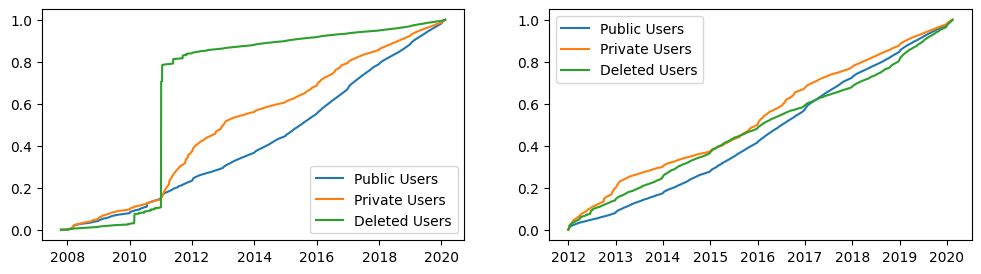

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].plot(joining_dates,joining_date_public_user_CDF,label ='Public Users')
axes[0].plot(joining_dates,joining_date_private_users_CDF,label ='Private Users')
axes[0].plot(joining_dates,joining_date_deleted_users_CDF,label ='Deleted Users')
axes[0].legend()

axes[1].plot(joining_dates_2011,joining_date_2011_public_user_CDF,label ='Public Users')
axes[1].plot(joining_dates_2011,joining_date_2011_private_users_CDF,label ='Private Users')
axes[1].plot(joining_dates_2011,joining_date_2011_deleted_users_CDF,label ='Deleted Users')
axes[1].legend()

# Number of commitment per user CDF (>=1)

In [38]:
commitments_per_user = [v['number_of_commitments'] for k,v in user_index.items() if v['number_of_commitments']>0]

In [39]:
sorted(Counter(commitments_per_user).items(), key=lambda x:x[1],reverse=True)[:10]

[(1, 150892),
 (2, 26443),
 (3, 8432),
 (4, 3608),
 (5, 1933),
 (6, 1153),
 (7, 711),
 (8, 532),
 (9, 356),
 (10, 296)]

In [40]:
unique_commitments_per_user = list(set(commitments_per_user))

In [41]:
unique_commitments_per_user.sort()

In [42]:
len(unique_commitments_per_user)

138

In [43]:
total_users_with_commitments = 0
for k,v in user_index.items():
    if v['number_of_commitments']>0:
        total_users_with_commitments+=1

In [44]:
no_of_commitments_CDF = np.zeros(len(unique_commitments_per_user))
for k,v in tqdm(user_index.items()):
    if v['number_of_commitments']>0:
        count_index = unique_commitments_per_user.index(v['number_of_commitments'])
        no_of_commitments_CDF[count_index:]+=1

  0%|          | 0/521632 [00:00<?, ?it/s]

In [45]:
no_of_commitments_CDF/=total_users_with_commitments

Removing outliars

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0ebeedad70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0ebeedb2b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0ebeedaad0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0ebeea9c00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0ebeedb730>],
 'means': []}

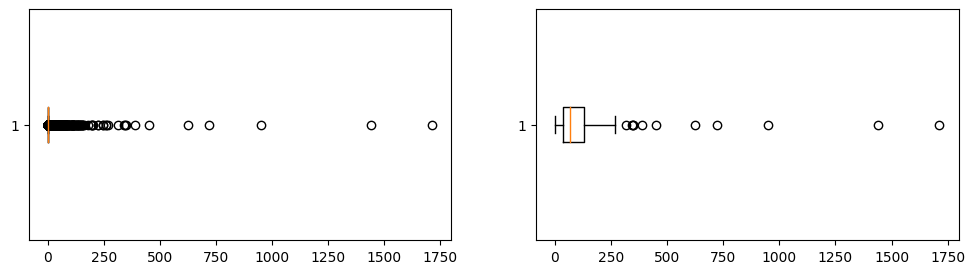

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].boxplot(commitments_per_user, vert=False)
axes[1].boxplot(unique_commitments_per_user, vert=False)

In [47]:
median, IQR, low_lim, up_lim = get_outlier(commitments_per_user)
median, IQR, low_lim, up_lim

(1.0, 0.0, 1.0, 1.0)

In [48]:
median, IQR, low_lim, up_lim = get_outlier(unique_commitments_per_user)
median, IQR, low_lim, up_lim

(69.5, 95.0, 1, 273.0)

In [49]:
unique_commitments_per_user_outlier = [i for i in unique_commitments_per_user if i>=low_lim and i<=up_lim]

In [50]:
unique_commitments_per_user_outlier.sort()

In [51]:
len(unique_commitments_per_user_outlier)

127

In [52]:
no_of_commitments_outlier_CDF = np.zeros(len(unique_commitments_per_user_outlier))
for k,v in tqdm(user_index.items()):
    if v['number_of_commitments']>=low_lim and v['number_of_commitments']<=up_lim:
        count_index = unique_commitments_per_user_outlier.index(v['number_of_commitments'])
        no_of_commitments_outlier_CDF[count_index:]+=1

  0%|          | 0/521632 [00:00<?, ?it/s]

In [53]:
no_of_commitments_outlier_CDF/=total_users_with_commitments

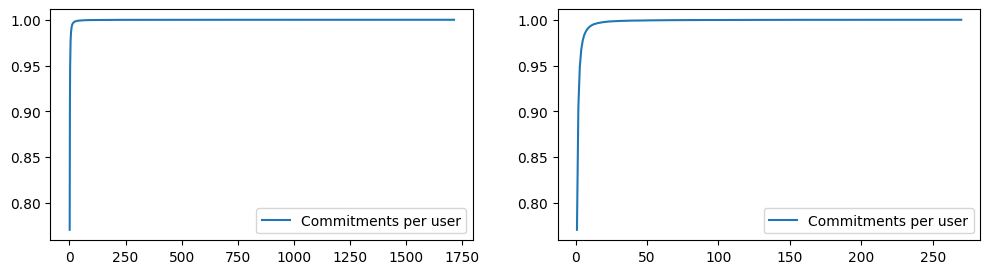

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].plot(unique_commitments_per_user,no_of_commitments_CDF,label ='Commitments per user')
axes[0].legend()

axes[1].plot(unique_commitments_per_user_outlier,no_of_commitments_outlier_CDF,label ='Commitments per user')
axes[1].legend()

In [55]:
for i in [99,95,90,80,75,50]:
    print(f"{i}%ile users have < {np.percentile(commitments_per_user, i, method = 'midpoint')} commitments")

99%ile users have < 9.0 commitments
95%ile users have < 4.0 commitments
90%ile users have < 2.0 commitments
80%ile users have < 2.0 commitments
75%ile users have < 1.0 commitments
50%ile users have < 1.0 commitments


# Default Display Image

In [56]:
display_image_default = [v['default_image'] for k,v in user_index.items()]

In [57]:
Counter(display_image_default)

Counter({True: 432720, False: 88912})

# No of commitments made Month

In [58]:
month_values = []
for y in range(2007,2024):
    for m in range(1,13):
        month_values.append(datetime(y,m,1)) 

In [59]:
commitment_count_date = np.zeros(len(month_values))
for k,v in tqdm(commitment_index.items()):
    start_m = datetime(v['start_date'].year,v['start_date'].month,1)
    date_index = month_values.index(start_m)
    commitment_count_date[date_index]+=1

  0%|          | 0/319928 [00:00<?, ?it/s]

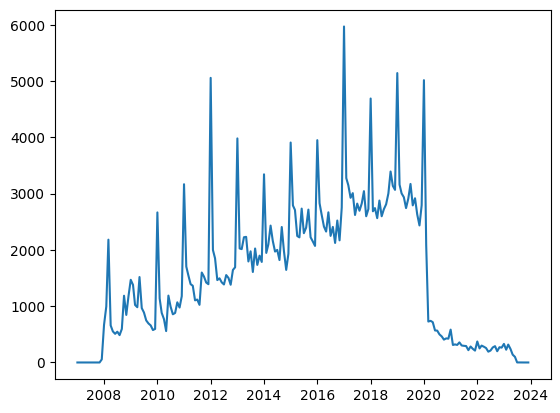

In [60]:
plt.plot(month_values,commitment_count_date)

## Length of commitment

In [61]:
commitment_lengths = [v['length_in_days'] for k,v in commitment_index.items()]

In [62]:
min(commitment_lengths),max(commitment_lengths)

(0, 17774)

In [63]:
sorted(Counter(commitment_lengths).items(), key=lambda x:x[1],reverse=True)

[(84, 43028),
 (56, 34649),
 (28, 25795),
 (112, 17298),
 (140, 15245),
 (7, 14079),
 (70, 12409),
 (364, 12277),
 (42, 9764),
 (35, 9174),
 (14, 8852),
 (2, 7914),
 (21, 7633),
 (105, 5285),
 (49, 4014),
 (168, 3973),
 (63, 3735),
 (91, 3528),
 (210, 3415),
 (98, 2854),
 (77, 2542),
 (175, 2462),
 (6, 2442),
 (126, 2333),
 (182, 2311),
 (3, 2289),
 (280, 2263),
 (350, 1998),
 (154, 1873),
 (4, 1842),
 (5, 1790),
 (1, 1672),
 (8, 1606),
 (119, 1577),
 (693, 1131),
 (245, 1113),
 (196, 1088),
 (147, 1071),
 (336, 1011),
 (31, 1003),
 (224, 973),
 (30, 934),
 (133, 906),
 (252, 820),
 (9, 797),
 (161, 788),
 (10, 710),
 (231, 706),
 (189, 657),
 (29, 643),
 (203, 575),
 (315, 573),
 (308, 563),
 (11, 556),
 (13, 521),
 (15, 506),
 (420, 506),
 (12, 502),
 (32, 484),
 (217, 467),
 (357, 444),
 (27, 427),
 (294, 424),
 (22, 413),
 (238, 400),
 (259, 389),
 (16, 384),
 (33, 381),
 (20, 377),
 (26, 363),
 (24, 350),
 (25, 345),
 (266, 343),
 (18, 339),
 (23, 323),
 (34, 310),
 (17, 306),
 (1

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0eba9037f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0eba903d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0eba903670>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0ebcd1c2b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0ebcd1c550>],
 'means': []}

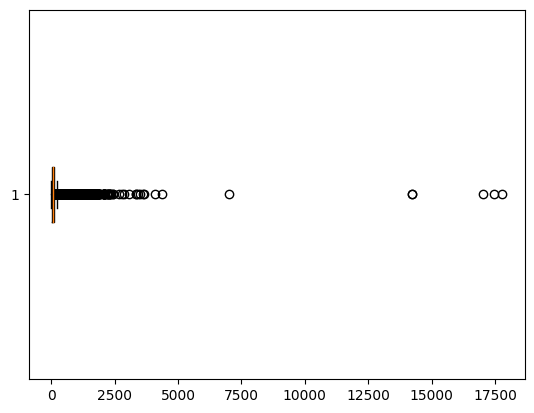

In [64]:
plt.boxplot(commitment_lengths,vert=False)

In [65]:
median, IQR, low_lim, up_lim = get_outlier(commitment_lengths)
median, IQR, low_lim, up_lim

(70.0, 84.0, 0, 238.0)

(array([18075., 18771., 11067.,  9854., 29550., 10466., 10764.,  4828.,
        35954.,  4408., 12908.,  3083., 43986.,  4265.,  3271.,  5601.,
        17925.,  1880.,  2537.,  1110., 15436.,  1296.,  2019.,   913.,
         4105.,  2654.,  2469.,   753.,  1183.,   678.,  3507.,   530.,
         1037.,  1181.]),
 array([  0.,   7.,  14.,  21.,  28.,  35.,  42.,  49.,  56.,  63.,  70.,
         77.,  84.,  91.,  98., 105., 112., 119., 126., 133., 140., 147.,
        154., 161., 168., 175., 182., 189., 196., 203., 210., 217., 224.,
        231., 238.]),
 <BarContainer object of 34 artists>)

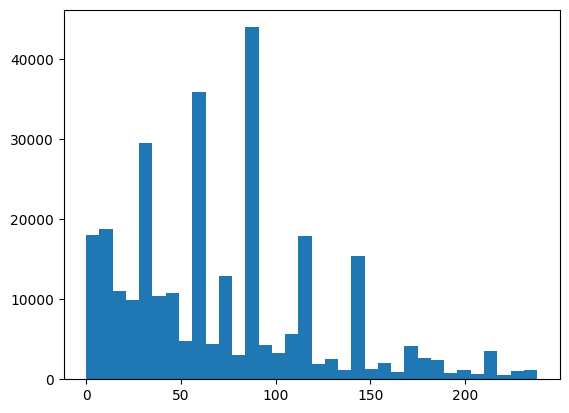

In [66]:
plt.hist(commitment_lengths, bins = [i for i in range(0,239,7)])

In [67]:
commitment_lengths = [int(i/7.0) for i in commitment_lengths]

In [68]:
unique_commitment_lengths = list(set(commitment_lengths))

In [69]:
unique_commitment_lengths.sort()

In [70]:
len(unique_commitment_lengths)

270

In [71]:
commitment_length_CDF = np.zeros(len(unique_commitment_lengths))
for k,v in tqdm(commitment_index.items()):
    count_idx = unique_commitment_lengths.index(int(v['length_in_days']/7.0))
    commitment_length_CDF[count_idx:]+=1

  0%|          | 0/319928 [00:00<?, ?it/s]

In [72]:
commitment_length_CDF/=len(commitment_index)

outliers

In [73]:
commitment_lengths_outlier = [int(i/7.0) for i in commitment_lengths if i>=low_lim and i<=up_lim]

In [74]:
unique_commitment_lengths_outlier = list(set(commitment_lengths_outlier))

In [75]:
min(unique_commitment_lengths_outlier),max(unique_commitment_lengths_outlier)

(0, 33)

In [76]:
len(unique_commitment_lengths_outlier)

34

In [77]:
commitment_length_outlier_CDF = np.zeros(len(unique_commitment_lengths_outlier))
for k,v in tqdm(commitment_index.items()):
    if v['length_in_days']>=low_lim and v['length_in_days']<=up_lim:
        count_idx = unique_commitment_lengths.index(int(v['length_in_days']/7.0))
        commitment_length_outlier_CDF[count_idx:]+=1

  0%|          | 0/319928 [00:00<?, ?it/s]

In [78]:
commitment_length_outlier_CDF/=len(commitment_index)

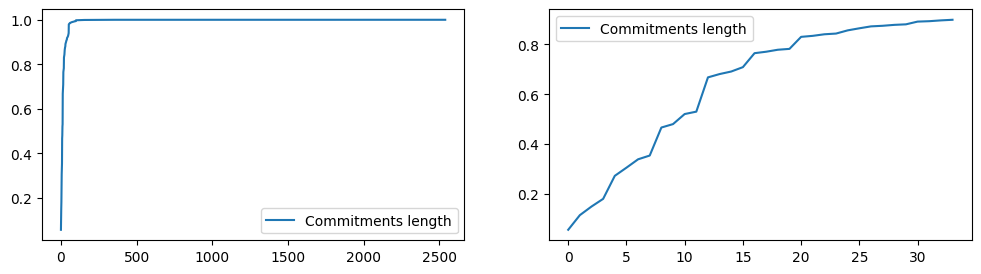

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].plot(unique_commitment_lengths,commitment_length_CDF,label ='Commitments length')
axes[0].legend()

axes[1].plot(unique_commitment_lengths_outlier,commitment_length_outlier_CDF,label ='Commitments length')
axes[1].legend()

# Date of start

Day 

In [80]:
day_of_start = [v['start_date'].day for k,v in commitment_index.items()]

In [81]:
counts = list(Counter(day_of_start).items())

In [82]:
counts.sort()

In [83]:
day = []
count = []
for i,j in counts:
    day.append(i)
    count.append(j)

<BarContainer object of 31 artists>

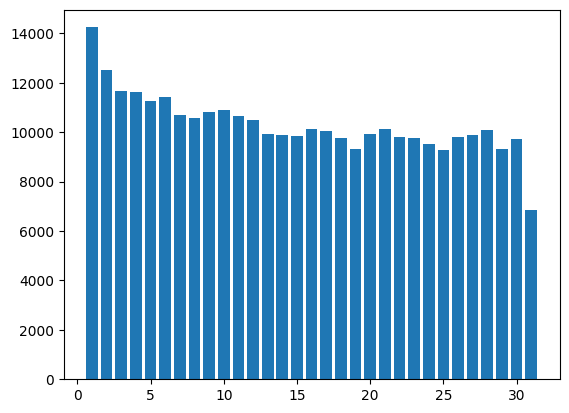

In [84]:
plt.bar(day,count)

month

In [85]:
month_of_start = [v['start_date'].month for k,v in commitment_index.items()]

In [86]:
counts = list(Counter(month_of_start).items())

In [87]:
counts.sort()

In [88]:
month = []
count = []
for i,j in counts:
    month.append(i)
    count.append(j)

<BarContainer object of 12 artists>

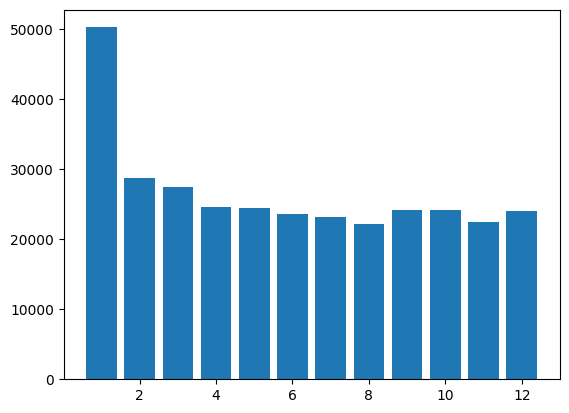

In [89]:
plt.bar(month,count)

365 days

In [90]:
day_of_year = []
count = []
for i in range(1,13):
    for j in range(1,32):
        day_of_year.append(f"{j}_{i}")
        count.append(0)

In [91]:
for k,v in commitment_index.items():
    idx = day_of_year.index(f"{v['start_date'].day}_{v['start_date'].month}")
    count[idx]+=1

In [92]:
max(count)

3472

<BarContainer object of 372 artists>

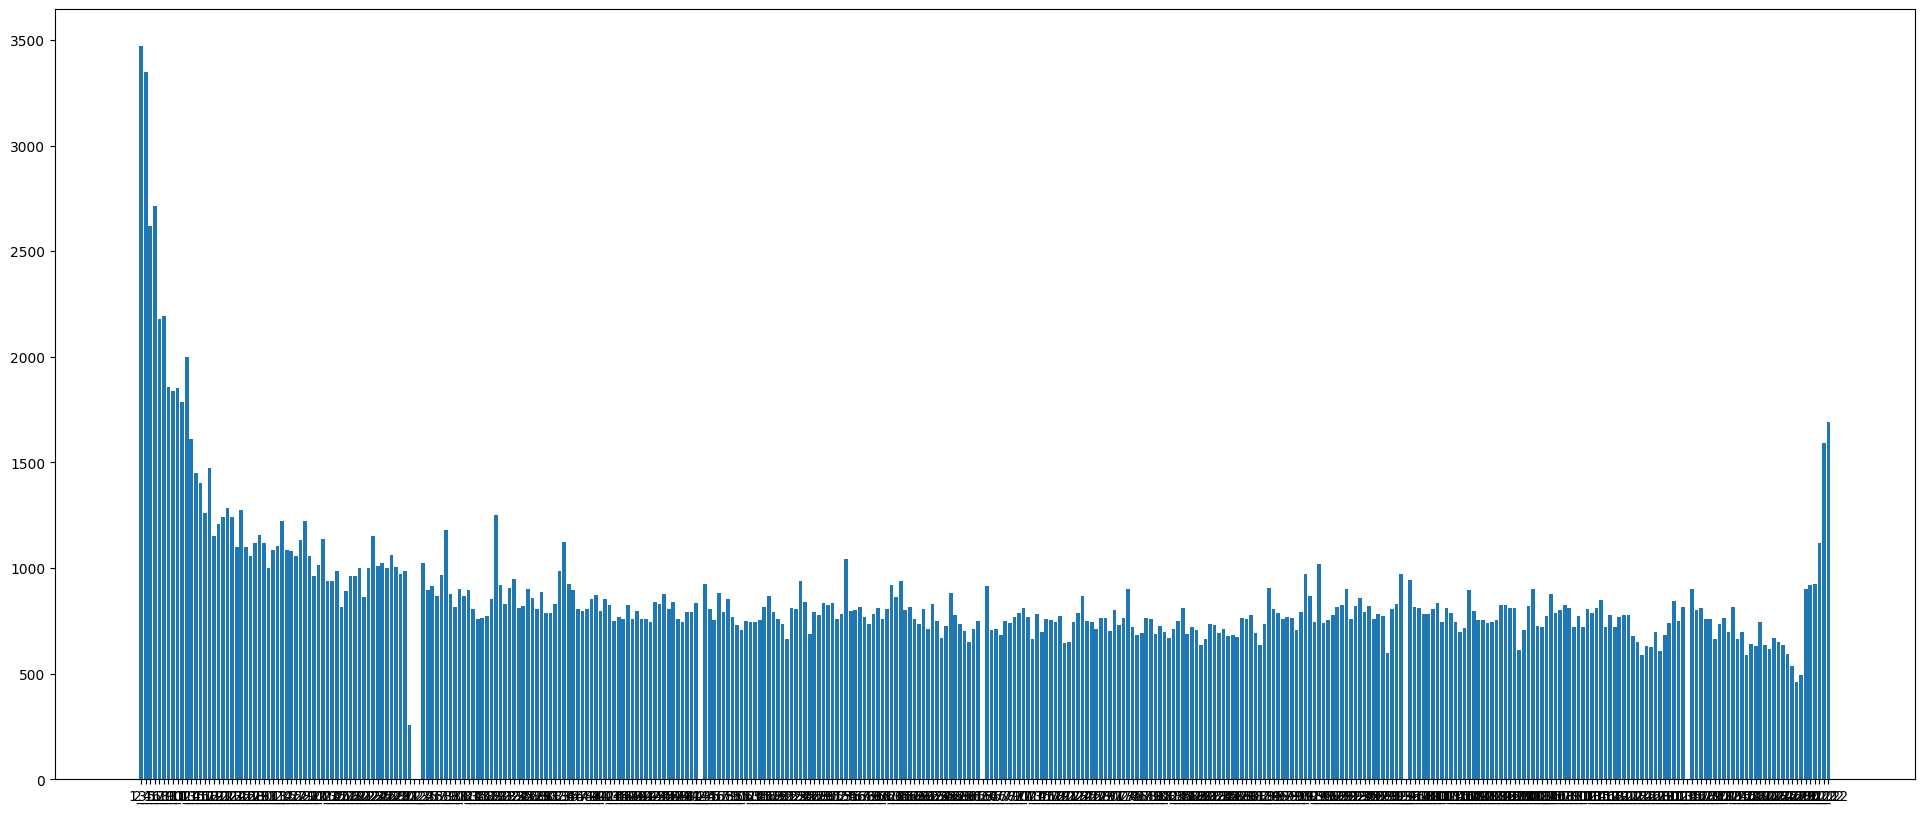

In [93]:
plt.figure(figsize=(24,10))
plt.bar(day_of_year,count)

In [94]:
count = np.array(count)

In [95]:
count=count[np.newaxis,:]

In [96]:

# ,norm=colors.LogNorm(vmin=min(foo), vmax=max(foo))

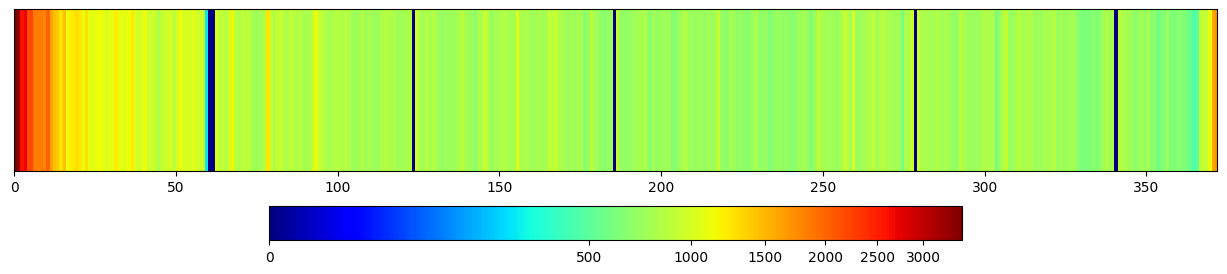

In [97]:
plt.figure(figsize=(24,3))
extent=[0, 372,0,50]
plt.imshow(count, cmap=plt.cm.jet,norm=colors.PowerNorm(gamma=0.4), extent=extent)
plt.gca().set_yticks([])
plt.colorbar(orientation='horizontal')
plt.show()

Weekday

In [98]:
weekday_of_start = [v['start_date'].weekday() for k,v in commitment_index.items()]

In [99]:
counts = list(Counter(weekday_of_start).items())

In [100]:
counts.sort()

In [101]:
day = []
count = []
for i,j in counts:
    day.append(i)
    count.append(j)

<BarContainer object of 7 artists>

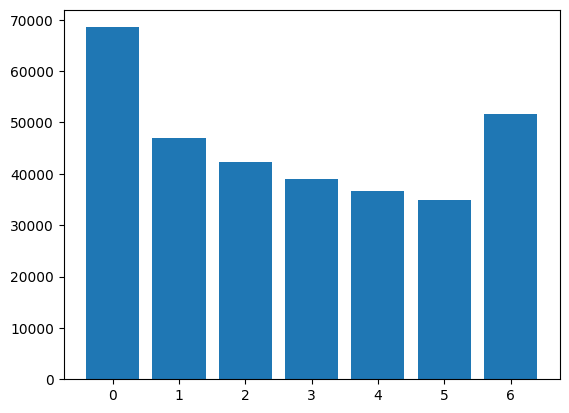

In [102]:
plt.bar(day,count)

# reporting Interval 

In [103]:
reporting_intervals = [int(v['days_per_reporting']) for k,v in commitment_index.items() if v['no_of_reports']>1]

In [104]:
len(reporting_intervals)

256847

In [105]:
len(set(reporting_intervals))

20

In [106]:
counts = list(Counter(reporting_intervals).items())

In [107]:
counts.sort()

In [108]:
counts

[(0, 3),
 (1, 6327),
 (2, 7),
 (3, 5),
 (4, 8),
 (5, 6),
 (6, 4),
 (7, 250460),
 (8, 7),
 (9, 3),
 (10, 2),
 (11, 2),
 (12, 3),
 (14, 2),
 (17, 1),
 (18, 1),
 (19, 1),
 (21, 2),
 (29, 2),
 (45, 1)]

# Stake Type 

In [109]:
stake_type = [v['type_of_stake'] for k,v in commitment_index.items()]

In [110]:
len(stake_type),len(set(stake_type))

(319928, 8)

In [111]:
stake_table = []
for k,v in Counter(stake_type).items():
    stake_table.append((k,v,100*v/len(commitment_index)))

In [112]:
pd.DataFrame(stake_table,columns=['Type','Count','%']).sort_values(by = '%', ascending=False)

,Type,Count,%
0,No stakes,219583,68.635130
3,Anti-charity,51535,16.108312
1,Charity,23248,7.266635
2,Money to a friend,18136,5.668775
4,stickK,4165,1.301855
5,Anti-charity_reverted,1407,0.439786
6,Money to a friend_reverted,998,0.311945
7,Charity_reverted,856,0.267560


## Amount of Stake

### Total stake

In [113]:
total_stake = [v['total_stake'] for k,v in commitment_index.items() if (v['type_of_stake']!='No stakes') and ('reverted' not in v['type_of_stake'])]

In [114]:
sorted(Counter(total_stake).items(), key=lambda x:x[1],reverse=True)[:10]

[(100.0, 8811),
 (50.0, 7503),
 (20.0, 5487),
 (40.0, 5060),
 (200.0, 4511),
 (5.0, 4445),
 (10.0, 4412),
 (60.0, 4369),
 (80.0, 3969),
 (120.0, 3298)]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0ebc8b0be0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0ebc8b1000>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0ebc8b0940>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0ebc8b1540>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0ebc8b17e0>],
 'means': []}

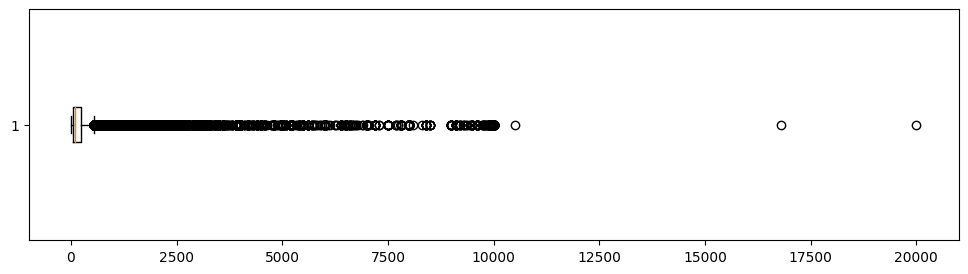

In [115]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
axes.boxplot(total_stake,vert=False)

In [116]:
median, IQR, low_lim, up_lim = get_outlier(total_stake)
median, IQR, low_lim, up_lim

(100.0, 200.0, 0.0, 540.0)

In [117]:
unique_total_stake = list(set(total_stake))

In [118]:
unique_total_stake.sort()

In [119]:
len(unique_total_stake)

1518

In [120]:
total_users_with_stake = 0
for k,v in commitment_index.items():
    if (v['type_of_stake']!='No stakes') and ('reverted' not in v['type_of_stake']):
        total_users_with_stake+=1
total_users_with_stake

97084

In [121]:
total_stake_CDF = np.zeros(len(unique_total_stake))
for k,v in tqdm(commitment_index.items()):
    if (v['type_of_stake']!='No stakes') and ('reverted' not in v['type_of_stake']):
        count_index = unique_total_stake.index(v['total_stake'])
        total_stake_CDF[count_index:]+=1

  0%|          | 0/319928 [00:00<?, ?it/s]

In [122]:
total_stake_CDF/=total_users_with_stake

outlier

In [123]:
total_stake_outlier = [i for i in total_stake if i>=low_lim and i<=up_lim]

In [124]:
min(total_stake_outlier),max(total_stake_outlier)

(0.0, 540.0)

In [125]:
unique_total_stake_outlier = list(set(total_stake_outlier))

In [126]:
unique_total_stake_outlier.sort()

In [127]:
len(unique_total_stake_outlier)

998

In [128]:
total_stake_outlier_CDF = np.zeros(len(unique_total_stake_outlier))
for k,v in tqdm(commitment_index.items()):
    if (v['type_of_stake']!='No stakes') and ('reverted' not in v['type_of_stake']) and v['total_stake']>=low_lim and v['total_stake']<=up_lim:
        count_index = unique_total_stake_outlier.index(v['total_stake'])
        total_stake_outlier_CDF[count_index:]+=1

  0%|          | 0/319928 [00:00<?, ?it/s]

In [129]:
total_stake_outlier_CDF/=total_users_with_stake

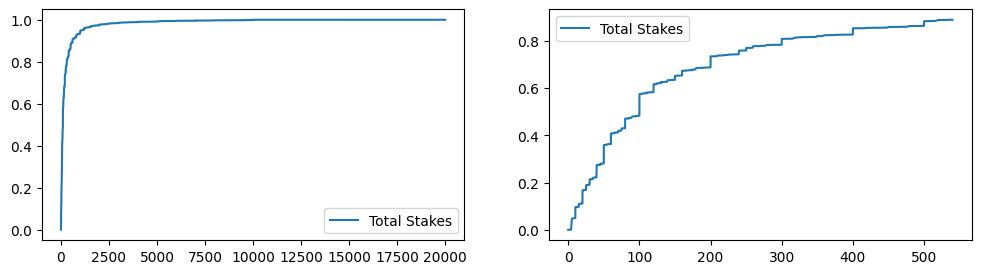

In [130]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].plot(unique_total_stake,total_stake_CDF,label ='Total Stakes')
axes[0].legend()

axes[1].plot(unique_total_stake_outlier,total_stake_outlier_CDF,label ='Total Stakes')
axes[1].legend()

#### Amount VS Type of Stake

In [131]:
unique_total_stake.sort()

In [132]:
len(unique_total_stake)

1518

In [133]:
stickK_users_with_stake = 0
Money_to_a_friend_users_with_stake = 0
Charity_users_with_stake = 0
Anti_charity_users_with_stake = 0
for k,v in commitment_index.items():
    if v['type_of_stake'] == 'stickK':
        stickK_users_with_stake+=1
    elif v['type_of_stake'] == 'Money to a friend':
        Money_to_a_friend_users_with_stake+=1
    elif v['type_of_stake'] == 'Charity':
        Charity_users_with_stake+=1
    elif v['type_of_stake'] == 'Anti-charity':
        Anti_charity_users_with_stake+=1

stickK_users_with_stake,Money_to_a_friend_users_with_stake,Charity_users_with_stake,Anti_charity_users_with_stake

(4165, 18136, 23248, 51535)

In [134]:
stickK_stake_CDF = np.zeros(len(unique_total_stake))
Money_to_a_friend_stake_CDF = np.zeros(len(unique_total_stake))
Charity_stake_CDF = np.zeros(len(unique_total_stake))
Anti_charity_stake_CDF = np.zeros(len(unique_total_stake))
for k,v in tqdm(commitment_index.items()):
    if v['type_of_stake'] == 'stickK':
        count_index = unique_total_stake.index(v['total_stake'])
        stickK_stake_CDF[count_index:]+=1
    elif v['type_of_stake'] == 'Money to a friend':
        count_index = unique_total_stake.index(v['total_stake'])
        Money_to_a_friend_stake_CDF[count_index:]+=1
    elif v['type_of_stake'] == 'Charity':
        count_index = unique_total_stake.index(v['total_stake'])
        Charity_stake_CDF[count_index:]+=1
    elif v['type_of_stake'] == 'Anti-charity':
        count_index = unique_total_stake.index(v['total_stake'])
        Anti_charity_stake_CDF[count_index:]+=1

  0%|          | 0/319928 [00:00<?, ?it/s]

In [135]:
stickK_stake_CDF/=stickK_users_with_stake
Money_to_a_friend_stake_CDF/=Money_to_a_friend_users_with_stake
Charity_stake_CDF/=Charity_users_with_stake
Anti_charity_stake_CDF/=Anti_charity_users_with_stake

In [136]:
stickK_stake_outlier_CDF = np.zeros(len(unique_total_stake_outlier))
Money_to_a_friend_stake_outlier_CDF = np.zeros(len(unique_total_stake_outlier))
Charity_stake_outlier_CDF = np.zeros(len(unique_total_stake_outlier))
Anti_charity_stake_outlier_CDF = np.zeros(len(unique_total_stake_outlier))
for k,v in tqdm(commitment_index.items()):
    if v['total_stake']>=low_lim and v['total_stake']<=up_lim:
        if v['type_of_stake'] == 'stickK':
            count_index = unique_total_stake_outlier.index(v['total_stake'])
            stickK_stake_outlier_CDF[count_index:]+=1
        elif v['type_of_stake'] == 'Money to a friend':
            count_index = unique_total_stake_outlier.index(v['total_stake'])
            Money_to_a_friend_stake_outlier_CDF[count_index:]+=1
        elif v['type_of_stake'] == 'Charity':
            count_index = unique_total_stake_outlier.index(v['total_stake'])
            Charity_stake_outlier_CDF[count_index:]+=1
        elif v['type_of_stake'] == 'Anti-charity':
            count_index = unique_total_stake_outlier.index(v['total_stake'])
            Anti_charity_stake_outlier_CDF[count_index:]+=1

  0%|          | 0/319928 [00:00<?, ?it/s]

In [137]:
stickK_stake_outlier_CDF/=stickK_users_with_stake
Money_to_a_friend_stake_outlier_CDF/=Money_to_a_friend_users_with_stake
Charity_stake_outlier_CDF/=Charity_users_with_stake
Anti_charity_stake_outlier_CDF/=Anti_charity_users_with_stake

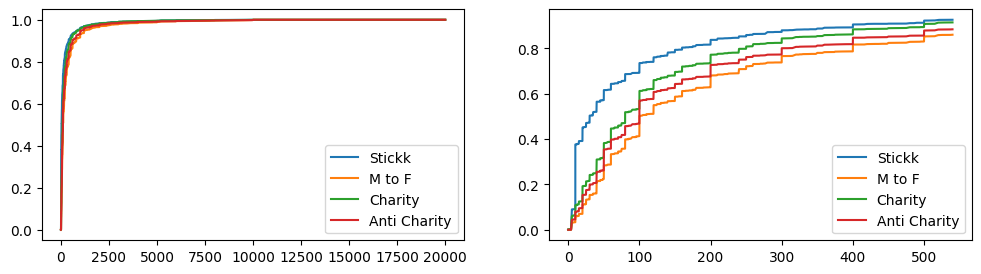

In [138]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].plot(unique_total_stake,stickK_stake_CDF,label ='Stickk')
axes[0].plot(unique_total_stake,Money_to_a_friend_stake_CDF,label ='M to F')
axes[0].plot(unique_total_stake,Charity_stake_CDF,label ='Charity')
axes[0].plot(unique_total_stake,Anti_charity_stake_CDF,label ='Anti Charity')
axes[0].legend()


axes[1].plot(unique_total_stake_outlier,stickK_stake_outlier_CDF,label ='Stickk')
axes[1].plot(unique_total_stake_outlier,Money_to_a_friend_stake_outlier_CDF,label ='M to F')
axes[1].plot(unique_total_stake_outlier,Charity_stake_outlier_CDF,label ='Charity')
axes[1].plot(unique_total_stake_outlier,Anti_charity_stake_outlier_CDF,label ='Anti Charity')
axes[1].legend()

### Stake per period

In [139]:
stake_per_period = [v['stake_per_period'] for k,v in commitment_index.items() if (v['type_of_stake']!='No stakes') and ('reverted' not in v['type_of_stake'])]

In [140]:
sorted(Counter(stake_per_period).items(), key=lambda x:x[1],reverse=True)

[(5.0, 22596),
 (10.0, 16949),
 (50.0, 12049),
 (20.0, 9667),
 (100.0, 9234),
 (25.0, 5229),
 (15.0, 2601),
 (30.0, 2341),
 (200.0, 1975),
 (40.0, 1623),
 (500.0, 1468),
 (300.0, 876),
 (150.0, 842),
 (1000.0, 748),
 (250.0, 725),
 (75.0, 653),
 (7.0, 514),
 (35.0, 488),
 (60.0, 370),
 (400.0, 254),
 (8.0, 247),
 (6.0, 234),
 (80.0, 220),
 (12.0, 206),
 (70.0, 196),
 (12.5, 173),
 (1.0, 146),
 (45.0, 130),
 (125.0, 124),
 (2000.0, 115),
 (11.0, 82),
 (800.0, 77),
 (120.0, 73),
 (49.0, 71),
 (14.0, 69),
 (90.0, 68),
 (13.0, 64),
 (7.5, 62),
 (600.0, 62),
 (700.0, 62),
 (1500.0, 60),
 (6.25, 56),
 (350.0, 56),
 (2.0, 54),
 (33.0, 53),
 (9.0, 53),
 (6.66, 49),
 (5000.0, 45),
 (18.0, 42),
 (21.0, 41),
 (3000.0, 40),
 (175.0, 40),
 (55.0, 40),
 (17.0, 39),
 (65.0, 37),
 (3.0, 36),
 (900.0, 34),
 (16.0, 33),
 (7000.0, 33),
 (24.0, 31),
 (750.0, 30),
 (140.0, 29),
 (62.5, 29),
 (31.25, 28),
 (22.0, 27),
 (450.0, 26),
 (9999.0, 25),
 (160.0, 23),
 (5.01, 23),
 (0.0, 22),
 (180.0, 22),
 (130.0,

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0ebc719990>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0ebc719ed0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0ebc7196f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0ebc71a410>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0ebc71a6b0>],
 'means': []}

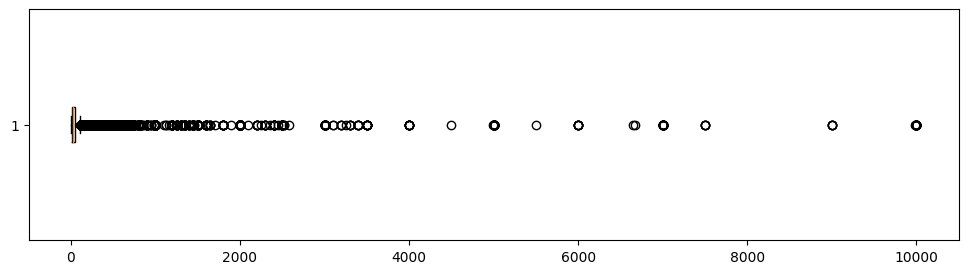

In [141]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
axes.boxplot(stake_per_period,vert=False)

In [142]:
median, IQR, low_lim, up_lim = get_outlier(stake_per_period)
median, IQR, low_lim, up_lim

(20.0, 42.5, 0.0, 113.75)

In [143]:
unique_stake_per_period = list(set(stake_per_period))

In [144]:
unique_stake_per_period.sort()

In [145]:
len(unique_stake_per_period)

864

In [146]:
stake_per_period_CDF = np.zeros(len(unique_stake_per_period))
for k,v in tqdm(commitment_index.items()):
    if (v['type_of_stake']!='No stakes') and ('reverted' not in v['type_of_stake']):
        count_index = unique_stake_per_period.index(v['stake_per_period'])
        stake_per_period_CDF[count_index:]+=1

  0%|          | 0/319928 [00:00<?, ?it/s]

In [147]:
stake_per_period_CDF/=total_users_with_stake

Outlier

In [148]:
stake_per_period_outlier = [i for i in stake_per_period if i>=low_lim and i<=up_lim]

In [149]:
min(stake_per_period_outlier),max(stake_per_period_outlier)

(0.0, 112.0)

In [150]:
unique_stake_per_period_outlier = list(set(stake_per_period_outlier))

In [151]:
unique_stake_per_period_outlier.sort()

In [152]:
len(unique_stake_per_period_outlier)

570

In [153]:
stake_per_period_outlier_CDF = np.zeros(len(unique_stake_per_period_outlier))
for k,v in tqdm(commitment_index.items()):
    if (v['type_of_stake']!='No stakes') and ('reverted' not in v['type_of_stake']) and v['stake_per_period']>=low_lim and v['stake_per_period']<=up_lim:
        count_index = unique_stake_per_period_outlier.index(v['stake_per_period'])
        stake_per_period_outlier_CDF[count_index:]+=1

  0%|          | 0/319928 [00:00<?, ?it/s]

In [154]:
stake_per_period_outlier_CDF/=total_users_with_stake

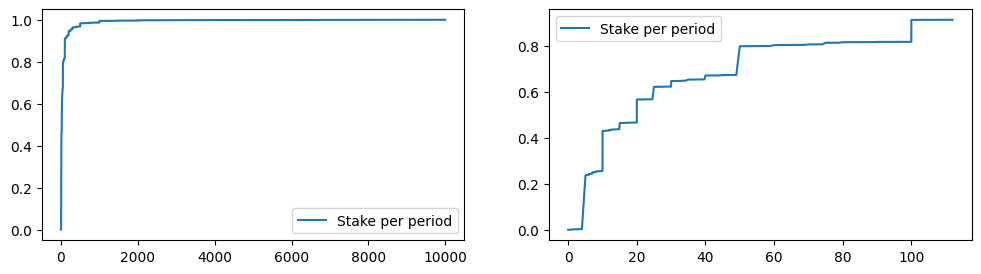

In [155]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].plot(unique_stake_per_period,stake_per_period_CDF,label ='Stake per period')
axes[0].legend()

axes[1].plot(unique_stake_per_period_outlier,stake_per_period_outlier_CDF,label ='Stake per period')
axes[1].legend()

#### Amount per period VS type of Stake

In [156]:
unique_stake_per_period.sort()

In [157]:
len(unique_stake_per_period)

864

In [158]:
stickK_stake_CDF = np.zeros(len(unique_stake_per_period))
Money_to_a_friend_stake_CDF = np.zeros(len(unique_stake_per_period))
Charity_stake_CDF = np.zeros(len(unique_stake_per_period))
Anti_charity_stake_CDF = np.zeros(len(unique_stake_per_period))
for k,v in tqdm(commitment_index.items()):
    if v['type_of_stake'] == 'stickK':
        count_index = unique_stake_per_period.index(v['stake_per_period'])
        stickK_stake_CDF[count_index:]+=1
    elif v['type_of_stake'] == 'Money to a friend':
        count_index = unique_stake_per_period.index(v['stake_per_period'])
        Money_to_a_friend_stake_CDF[count_index:]+=1
    elif v['type_of_stake'] == 'Charity':
        count_index = unique_stake_per_period.index(v['stake_per_period'])
        Charity_stake_CDF[count_index:]+=1
    elif v['type_of_stake'] == 'Anti-charity':
        count_index = unique_stake_per_period.index(v['stake_per_period'])
        Anti_charity_stake_CDF[count_index:]+=1

  0%|          | 0/319928 [00:00<?, ?it/s]

In [159]:
stickK_stake_CDF/=stickK_users_with_stake
Money_to_a_friend_stake_CDF/=Money_to_a_friend_users_with_stake
Charity_stake_CDF/=Charity_users_with_stake
Anti_charity_stake_CDF/=Anti_charity_users_with_stake

In [160]:
stickK_stake_outlier_CDF = np.zeros(len(unique_stake_per_period_outlier))
Money_to_a_friend_stake_outlier_CDF = np.zeros(len(unique_stake_per_period_outlier))
Charity_stake_outlier_CDF = np.zeros(len(unique_stake_per_period_outlier))
Anti_charity_stake_outlier_CDF = np.zeros(len(unique_stake_per_period_outlier))
for k,v in tqdm(commitment_index.items()):
    if v['stake_per_period']>=low_lim and v['stake_per_period']<=up_lim:
        if v['type_of_stake'] == 'stickK':
            count_index = unique_stake_per_period_outlier.index(v['stake_per_period'])
            stickK_stake_outlier_CDF[count_index:]+=1
        elif v['type_of_stake'] == 'Money to a friend':
            count_index = unique_stake_per_period_outlier.index(v['stake_per_period'])
            Money_to_a_friend_stake_outlier_CDF[count_index:]+=1
        elif v['type_of_stake'] == 'Charity':
            count_index = unique_stake_per_period_outlier.index(v['stake_per_period'])
            Charity_stake_outlier_CDF[count_index:]+=1
        elif v['type_of_stake'] == 'Anti-charity':
            count_index = unique_stake_per_period_outlier.index(v['stake_per_period'])
            Anti_charity_stake_outlier_CDF[count_index:]+=1

  0%|          | 0/319928 [00:00<?, ?it/s]

In [161]:
stickK_stake_outlier_CDF/=stickK_users_with_stake
Money_to_a_friend_stake_outlier_CDF/=Money_to_a_friend_users_with_stake
Charity_stake_outlier_CDF/=Charity_users_with_stake
Anti_charity_stake_outlier_CDF/=Anti_charity_users_with_stake

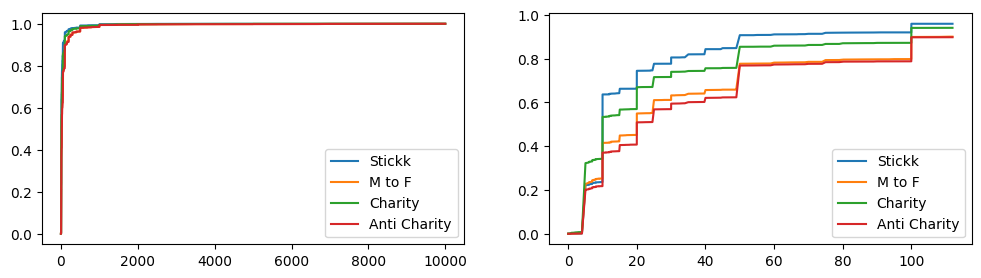

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].plot(unique_stake_per_period,stickK_stake_CDF,label ='Stickk')
axes[0].plot(unique_stake_per_period,Money_to_a_friend_stake_CDF,label ='M to F')
axes[0].plot(unique_stake_per_period,Charity_stake_CDF,label ='Charity')
axes[0].plot(unique_stake_per_period,Anti_charity_stake_CDF,label ='Anti Charity')
axes[0].legend()


axes[1].plot(unique_stake_per_period_outlier,stickK_stake_outlier_CDF,label ='Stickk')
axes[1].plot(unique_stake_per_period_outlier,Money_to_a_friend_stake_outlier_CDF,label ='M to F')
axes[1].plot(unique_stake_per_period_outlier,Charity_stake_outlier_CDF,label ='Charity')
axes[1].plot(unique_stake_per_period_outlier,Anti_charity_stake_outlier_CDF,label ='Anti Charity')
axes[1].legend()

## Refree 

In [163]:
refree = [v['self_refree'] for k,v in commitment_index.items()]

In [164]:
for k,v in Counter(refree).items():
    print(k,v,v*100/len(commitment_index))

True 256721 80.24336725763297
False 63207 19.75663274236703


### Support

In [165]:
supporters = [v['no_of_supporters'] for k,v in commitment_index.items()]

In [166]:
min(supporters),max(supporters)

(0, 19)

In [167]:
Counter(supporters)

Counter({0: 292374,
         1: 21265,
         2: 4104,
         3: 1234,
         4: 464,
         5: 200,
         6: 111,
         7: 49,
         8: 47,
         9: 36,
         11: 15,
         10: 15,
         13: 6,
         12: 3,
         14: 2,
         16: 1,
         15: 1,
         19: 1})

## Reporting Success, Not Reported, not successfull

In [168]:
sucessful = []
not_sucessful = []
not_reported = []
for k,v in tqdm(commitment_index.items()):
    sucessful.append(v['sucessful']*100/v['no_of_reports'])
    not_sucessful.append(v['not_sucessful']*100/v['no_of_reports'])
    not_reported.append(v['not_reported']*100/v['no_of_reports'])

  0%|          | 0/319928 [00:00<?, ?it/s]

(array([168138.,   9918.,   7687.,   4974.,   3427.,   6862.,   4461.,
          2439.,   3371.,    886.,   7060.,   2159.,   3475.,   3676.,
          1746.,   6656.,   5646.,   4652.,   5849.,  66846.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

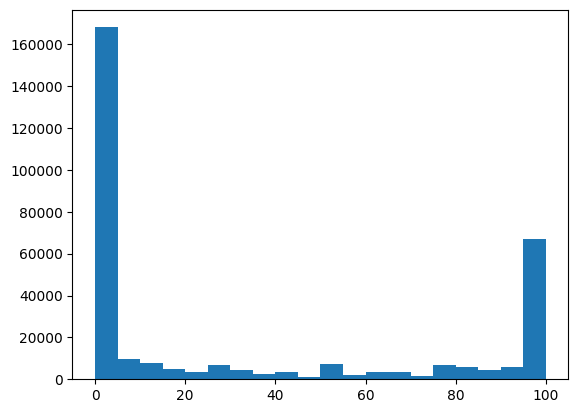

In [169]:
plt.hist(sucessful,bins = [i for i in range(0,101,5)])

(array([2.59618e+05, 1.30040e+04, 1.00590e+04, 5.58000e+03, 3.78400e+03,
        7.39900e+03, 3.70700e+03, 1.53900e+03, 2.05500e+03, 3.72000e+02,
        3.59100e+03, 6.18000e+02, 9.10000e+02, 8.02000e+02, 2.48000e+02,
        9.04000e+02, 4.33000e+02, 2.21000e+02, 1.62000e+02, 4.92200e+03]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

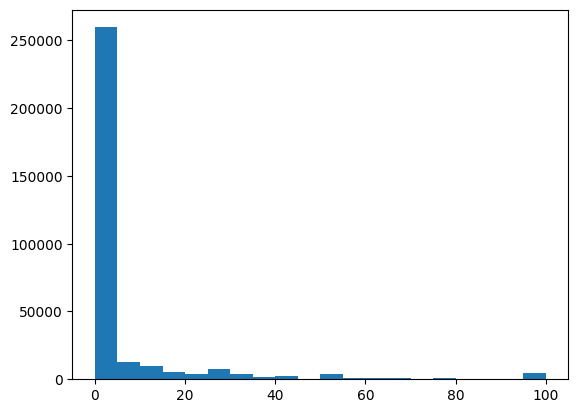

In [170]:
plt.hist(not_sucessful,bins = [i for i in range(0,101,5)])

(array([ 87238.,   5901.,   5736.,   3651.,   2490.,   5822.,   3481.,
          1905.,   2778.,    834.,   6101.,   2183.,   3193.,   3584.,
          1953.,   6503.,   6296.,   6497.,  10936., 152846.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

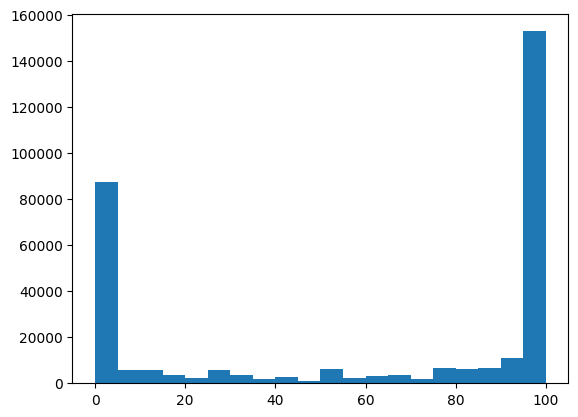

In [171]:
plt.hist(not_reported,bins = [i for i in range(0,101,5)])

## Length vs Success

In [172]:
duration = []
success_percentage = []

for k,v in commitment_index.items():
    duration.append(v['length_in_days'])
    success_percentage.append(v['sucessful']*100/v['no_of_reports'])

In [173]:
median, IQR, low_lim, up_lim = get_outlier(duration)
median, IQR, low_lim, up_lim

(70.0, 84.0, 0, 238.0)

In [174]:
# median, IQR, low_lim, up_lim = get_outlier(list(set(duration)))
# median, IQR, low_lim, up_lim

In [175]:
duration_outlier = []
success_percentage_outlier = []

for k,v in commitment_index.items():
    if v['length_in_days']>=low_lim and v['length_in_days']<=up_lim:
        duration_outlier.append(v['length_in_days'])
        success_percentage_outlier.append(v['sucessful']*100/v['no_of_reports'])

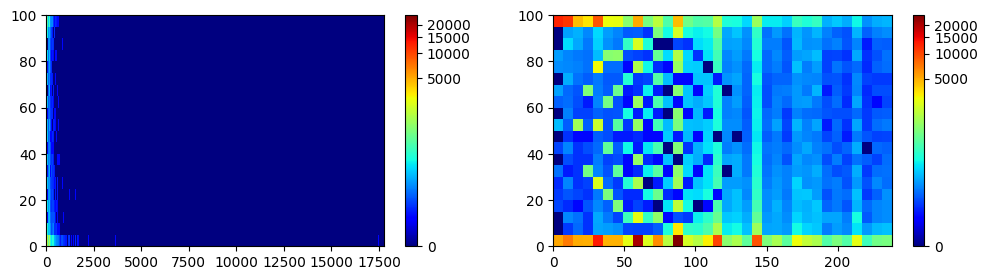

In [176]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist2d(duration, success_percentage, bins=(int(max(duration)/7), 20),norm=colors.PowerNorm(gamma=0.2), cmap=plt.cm.jet)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.hist2d(duration_outlier, success_percentage_outlier, bins=(int(max(duration_outlier)/7), 20),norm=colors.PowerNorm(gamma=0.2), cmap=plt.cm.jet)
plt.colorbar()

## Length vs Not reported

In [180]:
duration = []
not_reported_percentage = []

for k,v in commitment_index.items():
    duration.append(v['length_in_days'])
    not_reported_percentage.append(v['not_reported']*100/v['no_of_reports'])

In [181]:
duration_outlier = []
not_reported_percentage_outlier = []

for k,v in commitment_index.items():
    if v['length_in_days']>=low_lim and v['length_in_days']<=up_lim:
        duration_outlier.append(v['length_in_days'])
        not_reported_percentage_outlier.append(v['not_reported']*100/v['no_of_reports'])

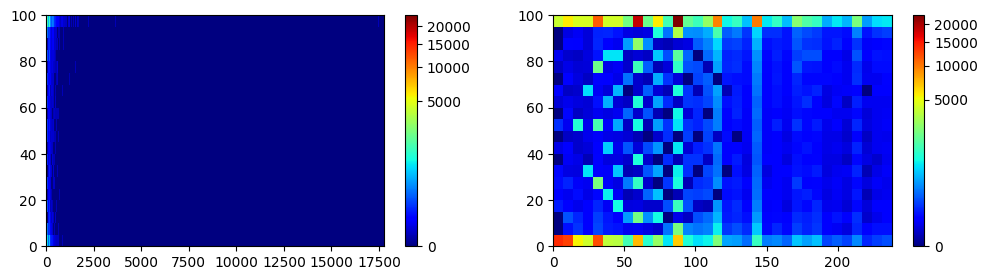

In [182]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist2d(duration, not_reported_percentage, bins=(int(max(duration)/7), 20),norm=colors.PowerNorm(gamma=0.3), cmap=plt.cm.jet)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.hist2d(duration_outlier, not_reported_percentage_outlier, bins=(int(max(duration_outlier)/7), 20),norm=colors.PowerNorm(gamma=0.3), cmap=plt.cm.jet)
plt.colorbar()

## Stake_per_period vs Success

In [183]:
stake = []
success_percentage = []

for k,v in commitment_index.items():
    stake.append(v['stake_per_period'])
    success_percentage.append(v['sucessful']*100/v['no_of_reports'])

In [184]:
median, IQR, low_lim, up_lim = get_outlier(list(set(stake)))
median, IQR, low_lim, up_lim

(35.36, 202.85, 0.0, 515.49)

In [185]:
# median, IQR, low_lim, up_lim = get_outlier(stake)
# median, IQR, low_lim, up_lim

In [186]:
stake_outlier = []
success_percentage_outlier = []

for k,v in commitment_index.items():
    if v['stake_per_period']>=low_lim and v['stake_per_period']<=up_lim:
        stake_outlier.append(v['stake_per_period'])
        success_percentage_outlier.append(v['sucessful']*100/v['no_of_reports'])

In [187]:
foo = Counter(success_percentage).values()

In [188]:
min(foo),max(foo)

(1, 162514)

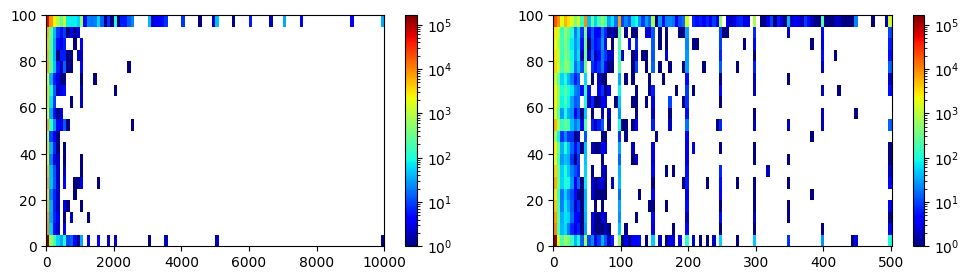

In [189]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist2d(stake, success_percentage, bins=(int(max(stake)/100), 20),norm=colors.LogNorm(vmin=min(foo), vmax=max(foo)), cmap=plt.cm.jet)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.hist2d(stake_outlier, success_percentage_outlier, bins=(int(max(stake_outlier)/5), 20),norm=colors.LogNorm(vmin=min(foo), vmax=max(foo)), cmap=plt.cm.jet)
plt.colorbar()

## Total Stake vs success

In [187]:
stake = []
success_percentage = []

for k,v in commitment_index.items():
    stake.append(v['total_stake'])
    success_percentage.append(v['sucessful']*100/v['no_of_reports'])

In [188]:
median, IQR, low_lim, up_lim = get_outlier(list(set(stake)))
median, IQR, low_lim, up_lim

(216.5, 946.635, 0.0, 2419.9075)

In [189]:
# median, IQR, low_lim, up_lim = get_outlier(stake)
# median, IQR, low_lim, up_lim

In [190]:
stake_outlier = []
success_percentage_outlier = []

for k,v in commitment_index.items():
    if v['total_stake']>=low_lim and v['total_stake']<=up_lim:
        stake_outlier.append(v['total_stake'])
        success_percentage_outlier.append(v['sucessful']*100/v['no_of_reports'])

In [191]:
foo = Counter(success_percentage).values()

In [192]:
min(foo),max(foo)

(1, 162514)

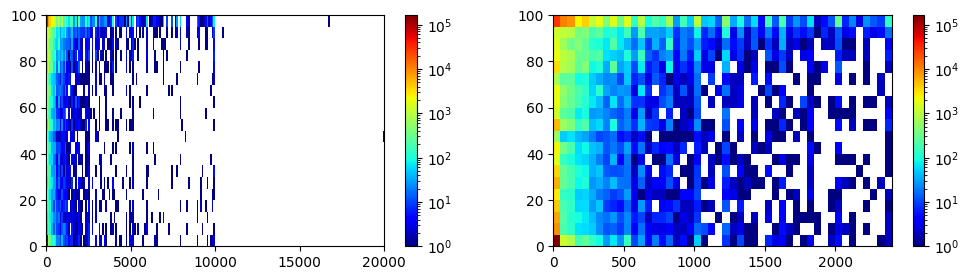

In [193]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist2d(stake, success_percentage, bins=(int(max(stake)/100), 20),norm=colors.LogNorm(vmin=min(foo), vmax=max(foo)), cmap=plt.cm.jet)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.hist2d(stake_outlier, success_percentage_outlier, bins=(int(max(stake_outlier)/50), 20),norm=colors.LogNorm(vmin=min(foo), vmax=max(foo)), cmap=plt.cm.jet)
plt.colorbar()

# Type of Stake vs success

In [194]:
stake_data = defaultdict(lambda: {"sucessful":[],"not_sucessful":[],"not_reported":[]})
for k,v in commitment_index.items():
    stake_data[v['type_of_stake']]['sucessful'].append(v['sucessful']*100/v['no_of_reports'])
    stake_data[v['type_of_stake']]['not_sucessful'].append(v['not_sucessful']*100/v['no_of_reports'])
    stake_data[v['type_of_stake']]['not_reported'].append(v['not_reported']*100/v['no_of_reports'])

In [195]:
raw_data = []
for k,v in stake_data.items():
    temp = [k]
    for i in ['sucessful','not_sucessful','not_reported']:
        temp.append(f'{np.mean(v[i]):.2f} ± {np.std(v[i])}')
    raw_data.append(temp)

In [196]:
pd.DataFrame(raw_data,columns=['Type',"Success", "Not Success" , "Not reported"]).sort_values(by = 'Success', ascending=False)

,Type,Success,Not Success,Not reported
3,Anti-charity,86.19 ± 27.258913287090948,5.31 ± 16.454846686942343,8.51 ± 22.141777647508558
4,stickK,83.49 ± 31.595992894096636,6.88 ± 20.83067538996798,9.63 ± 25.295885698425803
2,Money to a friend,74.91 ± 33.77186093792486,9.89 ± 21.0946797006917,15.20 ± 28.19865572758647
1,Charity,73.80 ± 34.65915071630355,8.95 ± 20.36165982193976,17.25 ± 30.388245227269714
5,Anti-charity_reverted,42.96 ± 28.55625373542365,8.17 ± 13.023256357703087,48.87 ± 30.58956813531778
7,Charity_reverted,37.62 ± 28.321864035185914,8.25 ± 13.533238086266142,54.13 ± 31.065508273707625
6,Money to a friend_reverted,37.20 ± 28.240680510109584,11.14 ± 16.309139830203435,51.66 ± 31.748934824325858
0,No stakes,11.76 ± 25.853973782017388,5.13 ± 15.785760966440307,83.10 ± 31.598797823213324


# Title Word cloud

In [197]:
titles = [v['title'] for k,v in commitment_index.items()]

In [198]:
titles = [i.lower() for i in titles]

In [199]:
titles = [i for i in titles if i!=""]

In [200]:
titles = [i.translate(str.maketrans('', '', string.punctuation)) for i in titles]

In [201]:
tokens = []
for i in titles:
    for k in i.split(" "):
        tokens.append(k)

In [202]:
tokens = [i for i in tokens if i!=""]

In [203]:
sorted(Counter(tokens).items(), key=lambda x:x[1],reverse=True)

[('weight', 85414),
 ('lose', 83330),
 ('exercise', 58723),
 ('regularly', 57206),
 ('a', 16608),
 ('my', 11136),
 ('to', 10865),
 ('for', 9665),
 ('quit', 9473),
 ('and', 9097),
 ('day', 8499),
 ('smoking', 8420),
 ('no', 8354),
 ('the', 7420),
 ('week', 7293),
 ('of', 6774),
 ('in', 6499),
 ('at', 5649),
 ('on', 5491),
 ('get', 5198),
 ('study', 4979),
 ('up', 4873),
 ('every', 4670),
 ('daily', 4660),
 ('finish', 4562),
 ('by', 4182),
 ('work', 4051),
 ('read', 3856),
 ('per', 3753),
 ('write', 3718),
 ('more', 3437),
 ('eat', 3406),
 ('i', 3282),
 ('5', 3255),
 ('1', 3200),
 ('race', 3153),
 ('2', 3014),
 ('complete', 2953),
 ('3', 2931),
 ('days', 2911),
 ('learn', 2892),
 ('do', 2829),
 ('stop', 2783),
 ('hours', 2678),
 ('wake', 2546),
 ('maintain', 2365),
 ('30', 2329),
 ('10', 2320),
 ('be', 2291),
 ('time', 2264),
 ('everyday', 2228),
 ('meditate', 2219),
 ('eating', 2201),
 ('or', 2197),
 ('book', 2042),
 ('one', 2042),
 ('drink', 2008),
 ('with', 2004),
 ('not', 1991),
 ('s

In [204]:
wc_text = " ".join(tokens)

In [205]:
len(wc_text)

5877551

In [206]:
wordcloud = WordCloud(stopwords=set(STOPWORDS) ,background_color="white").generate(wc_text)

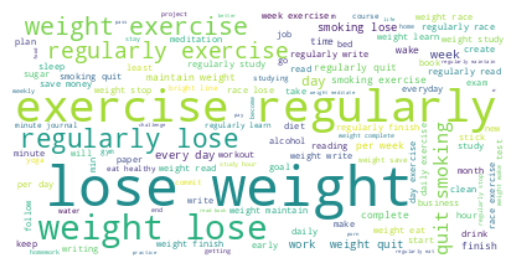

In [207]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Not reported and never came back

In [242]:
future_commitments = []
no_report_percentage = []

for k,v in tqdm(commitment_index.items()):
    no_report_percentage.append(v['not_reported']*100/v['no_of_reports'])
    count = 0
    cut_off_date = v['end_date']
    for c_id in user_index[str(v['user_id'])]['commitments']:
        if commitment_index[str(c_id)] != k:
            if commitment_index[str(c_id)]['start_date']>=cut_off_date:
                count+=1
    future_commitments.append(count)

  0%|          | 0/319928 [00:00<?, ?it/s]

In [243]:
len(future_commitments),len(no_report_percentage)

(319928, 319928)

In [244]:
min(future_commitments),max(future_commitments)

(0, 1712)

In [245]:
no_report_percentage, future_commitments = zip(*[(i,j) for i,j in zip(no_report_percentage,future_commitments) if j>0])

In [246]:
len(future_commitments),len(no_report_percentage)

(73446, 73446)

In [247]:
min(future_commitments),max(future_commitments)

(1, 1712)

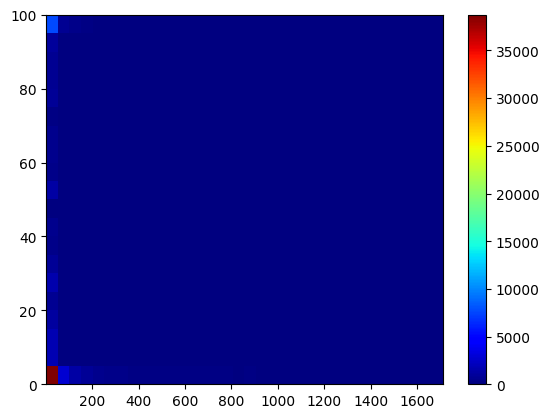

In [248]:
plt.hist2d(future_commitments, no_report_percentage, bins=(int(max(future_commitments)/50), 20), cmap=plt.cm.jet)
plt.colorbar()

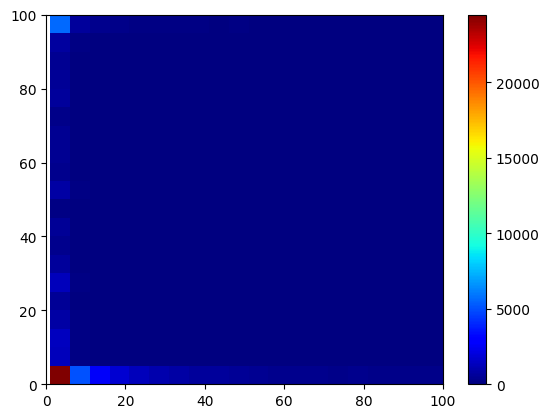

In [249]:
plt.hist2d(future_commitments, no_report_percentage, bins=(int(max(future_commitments)/5), 20), cmap=plt.cm.jet)
plt.xlim((0,100))
plt.colorbar()

# money lost

In [251]:
money_no_report = []
money_no_sucessful = []

for k,v in tqdm(commitment_index.items()):
    money_no_sucessful.append(v['stake_per_period']*v['not_sucessful'])
    money_no_report.append(v['stake_per_period']*v['not_reported'])

  0%|          | 0/319928 [00:00<?, ?it/s]

In [253]:
sum(money_no_report), sum(money_no_sucessful)

(3139515.919999997, 1329042.23)